# Parallelizing Neural Network Training with Theano

In [1]:
import theano
from theano import tensor as T

In [2]:
# initialize
x1 = T.scalar()
w0 = T.scalar()
w1 = T.scalar()
z1 = w1 * x1 + w0

In [3]:
# compile
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

In [4]:
# execute
print('Net output: %.2f' % net_input(2.0, 1.0, 0.5))

Net output: 2.50


## Configuring Theano

In [5]:
print(theano.config.floatX)

float64


In [6]:
theano.config.floatX = 'float32'

In [7]:
print(theano.config.device)

cpu


## Working with array structures

In [8]:
import numpy as np

In [9]:
# initialize
# if you are running Theano on 64 bit mode
# you need to use dmatrix instead of fmatrix
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

In [10]:
# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)

In [11]:
# execute
ary = [[1,2,3],[1,2,3]]
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]


In [12]:
# execute (NumPy array)
ary = np.array([[1,2,3],[1,2,3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [ 2.  4.  6.]


In [13]:
# initialize
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[x],
                            updates=update,
                            outputs=z)
# execute
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)

for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [14]:
# 'givens' transfers and keeps data in the network registries

# initialize
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[],
                            updates=update,
                            givens={x: data},
                            outputs=z)
# execute
for i in range(5):
    print('z:', net_input())

z: [[ 0.]]
z: [[ 6.]]
z: [[ 12.]]
z: [[ 18.]]
z: [[ 24.]]


# Wrapping things up – a linear regression example

In [15]:
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0], 
                      [5.0], [6.0], [7.0], [8.0], [9.0]], dtype=theano.config.floatX)
y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], dtype=theano.config.floatX)

In [16]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):
    
    costs = []
    # Initialize arrays
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y')
    X = T.fmatrix(name='X')
    
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1), 
                               dtype=theano.config.floatX), 
                      name='w')
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2))
    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]
    # compile model
    train = theano.function(inputs=[eta0], 
                            outputs=cost, 
                            updates=update, 
                            givens={X: X_train, y: y_train,})
    for _ in range(epochs):
        costs.append(train(eta))

    return costs, w

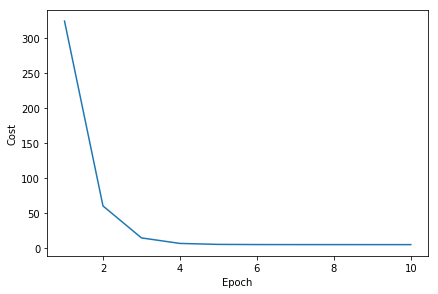

In [17]:
import matplotlib.pyplot as plt
costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [18]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt],
    givens={w: w},
    outputs=net_input)
    return predict(X)

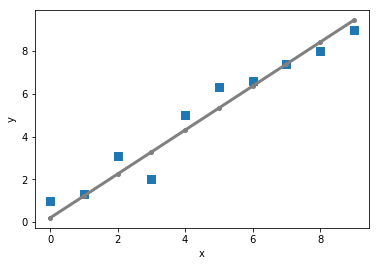

In [19]:
plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), predict_linreg(X_train, w), 
         color='gray', marker='o', markersize=4, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Choosing activation functions for feedforward neural networks
### Logistic function recap

In [20]:
X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])
def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


In [21]:
# W : array, shape = [n_output_units, n_hidden_units+1]
# Weight matrix for hidden layer -> output layer.
# note that first column (A[:][0] = 1) are the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])
# A : array, shape = [n_hidden+1, n_samples]
# Activation of hidden layer.
# note that first element (A[0][0] = 1) is the bias unit
A = np.array([[1.0],
              [0.1],
              [0.3],
              [0.7]])
# Z : array, shape = [n_output_units, n_samples]
# Net input of the output layer.
Z = W.dot(A)
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


In [22]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


## Estimating probabilities in multi-class classification via the softmax function

In [23]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)
y_probas.sum()

Probabilities:
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


1.0

In [24]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


## Broadening the output spectrum by using a hyperbolic tangent

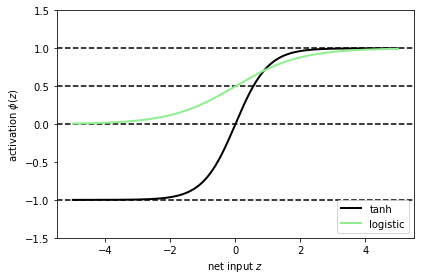

In [25]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)

log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.plot(z, tanh_act,
         linewidth=2,
         color='black',
         label='tanh')
plt.plot(z, log_act,
         linewidth=2,
         color='lightgreen',
         label='logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [26]:
tanh_act = np.tanh(z)
from scipy.special import expit
log_act = expit(z)

## Training neural networks efficiently using Keras

In [27]:
import os
import struct
import numpy as np
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

In [28]:
X_train, y_train = load_mnist('./downloads/mnist', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('./downloads/mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [29]:
import theano
theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

In [30]:
from keras.utils import np_utils
print('First 3 labels: ', y_train[:3])
y_train_ohe = np_utils.to_categorical(y_train)
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

Using Theano backend.


First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [31]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)
model = Sequential()
model.add(Dense(input_dim=X_train.shape[1],
                units=50,
                kernel_initializer='uniform',
                activation='tanh'))
model.add(Dense(input_dim=50,
                units=50,
                kernel_initializer='uniform',
                activation='tanh'))
model.add(Dense(input_dim=50,
                units=y_train_ohe.shape[1],
                kernel_initializer='uniform',
                activation='softmax'))
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [32]:
model.fit(X_train,
          y_train_ohe,
          epochs=50,
          batch_size=300,
          verbose=1,
          validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 2s - loss: 2.2244 - acc: 0.4250 - val_loss: 2.1018 - val_acc: 0.5730
Epoch 2/50
54000/54000 [==============================] - 2s - loss: 1.8741 - acc: 0.5320 - val_loss: 1.5895 - val_acc: 0.5780
Epoch 3/50
54000/54000 [==============================] - 2s - loss: 1.3820 - acc: 0.6151 - val_loss: 1.1457 - val_acc: 0.7172
Epoch 4/50
54000/54000 [==============================] - 2s - loss: 1.0404 - acc: 0.7196 - val_loss: 0.8644 - val_acc: 0.7940
Epoch 5/50
54000/54000 [==============================] - 2s - loss: 0.8205 - acc: 0.7934 - val_loss: 0.6877 - val_acc: 0.8472
Epoch 6/50
54000/54000 [==============================] - 2s - loss: 0.6786 - acc: 0.8348 - val_loss: 0.5736 - val_acc: 0.8745
Epoch 7/50
54000/54000 [==============================] - 2s - loss: 0.5804 - acc: 0.8591 - val_loss: 0.5010 - val_acc: 0.8820
Epoch 8/50
54000/54000 [==============================] - 2s -

In [33]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

First 3 predictions:  [5 0 4]
Training accuracy: 94.15%
Test accuracy: 93.76%
